In [1]:
import math
import numpy as np
from dataclasses import replace
import qutip
from qutip.control.pulseoptim import optimize_pulse_unitary
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import pathlib, sys

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
from tools.jupyter import print_model_info

In [4]:
n_bosons = 3
phase = 0  # np.pi / 4
# model = BEC_Qubits.init_alexey2003(n_bosons=n_bosons, phase=phase)
model = bec.BEC_Qubits.init_default(n_bosons=n_bosons, phase=phase)
print_model_info(model)

BEC_Qubits(n_bosons=3, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=False, communication_line=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Начальное состояние системы: суперпозиция на каждом кубите 

In [5]:
psi_initial = (
    bec.coherent_state_constructor(model, 2, 0)
    * bec.coherent_state_constructor(model, 2, 1)
    * bec.vacuum_state(model, n=2)
)

Целовое состояния: первное состояние с максимальной энтропией под действием H_zz

In [6]:
t_target = 0.4
psi_target = bec.state_under_h_zz_teor(model, t_target / model.Omega)

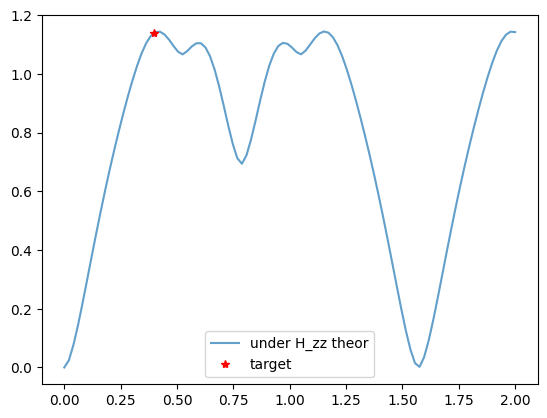

In [7]:
tspan = np.linspace(0, 2, 100)
plt.plot(
    tspan,
    [
        qutip.entropy_vn(
            qutip.ptrace(bec.state_under_h_zz_teor(model, t / model.Omega), [0, 1])
        )
        for t in tspan
    ],
    alpha=0.7,
    label="under H_zz theor",
)
plt.plot(
    t_target, qutip.entropy_vn(qutip.ptrace(psi_target, [0, 1])), "*r", label="target"
)
plt.legend()

Время оптимизации

In [8]:
n_ts, evo_time = 100, t_target

tspan = np.linspace(0, evo_time, n_ts)

В качестве основного гамильтониана выбираем $H_\mathrm{XY}$ из работы Jonas Kitzinger et al. Two-axis two-spin squeezed states. PHYSICAL REVIEW RESEARCH 2, 033504 (2020)


In [9]:
H_d = bec.sx(model, n=2, k=0) * bec.sx(model, n=2, k=1) - bec.sy(
    model, n=2, k=0
) * bec.sy(model, n=2, k=1)

Эволюция под действием основного гамильтониана

In [10]:
evolution_drift = qutip.mesolve(
    H_d,
    psi_initial,
    tspan,
    options=qutip.Options(nsteps=1e6),
)

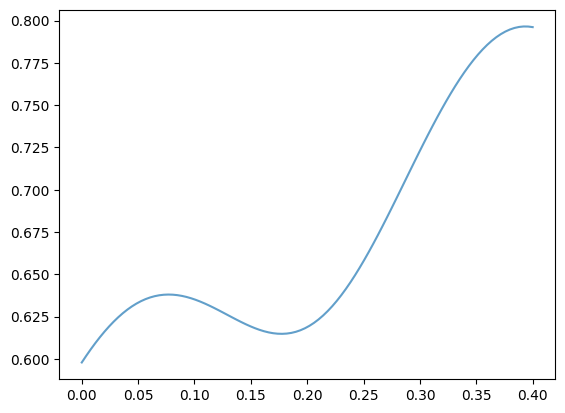

In [11]:
plt.plot(
    tspan,
    [qutip.metrics.fidelity(psi_target, psi) for psi in evolution_drift.states],
    alpha=0.7,
    label="H_d",
)

В качестве контроля выбираем вращение вокруг осей. 

Поворот вокруг оси Z после оптимизации получается нулевой. 

In [12]:
H_c = [
    bec.sx(model, n=2, k=0),
    # bec.sy(model, n=2, k=0),
    bec.sx(model, n=2, k=1),
    # bec.sy(model, n=2, k=1)
]

Оптимизация импулься

In [13]:
fid_err_targ = 1e-3
max_iter = 500
max_wall_time = 3e2
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = "RND"

In [14]:
%%time

min_grad = 1e-7

result_grape = optimize_pulse_unitary(
    H_d,
    H_c,
    psi_initial,
    psi_target,
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    min_grad=min_grad,
    init_pulse_type=p_type,
    gen_stats=True,
)  # or use `optimize_pulse` with  dyn_type='UNIT'

result_grape.fidelity, result_grape.fid_err

CPU times: user 36min 26s, sys: 5min 31s, total: 41min 58s
Wall time: 5min 38s


(0.0, 0.16061700425826575)

In [15]:
result_grape.stats.report()


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:05:38.385437
Wall time computing Hamiltonians: 0:00:00.488370 (0.14%)
Wall time computing propagators: 0:05:34.615373 (98.89%)
Wall time computing forward propagation: 0:00:01.172703 (0.35%)
Wall time computing onward propagation: 0:00:00.096081 (0.03%)
Wall time computing gradient: 0:00:01.992205 (0.59%)

**** Iterations and function calls ****
Number of iterations: 3
Number of fidelity function calls: 5
Number of times fidelity is computed: 5
Number of gradient function calls: 5
Number of times gradients are computed: 5
Number of times timeslot evolution is recomputed: 5

**** Control amplitudes ****
Number of control amplitude updates: 4
Mean number of updates per iteration: 1.3333333333333333
Number of timeslot values changed: 400
Mean number of timeslot changes per update: 100.0
Number of amplitude values changed: 800
Mean number

Полученные амплитуды для контроля

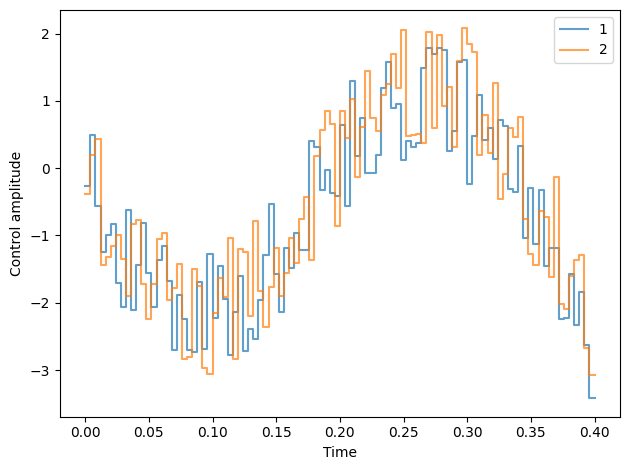

In [16]:
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

for i in range(len(H_c)):
    ax.step(
        result_grape.time,
        np.hstack((result_grape.final_amps[:, i], result_grape.final_amps[-1, i])),
        where="post",
        alpha=0.7,
        label=f"{i + 1}",
    )

ax.set_xlabel("Time")
ax.set_ylabel("Control amplitude")
ax.legend()
plt.tight_layout()
plt.show()

Временная зависимость фиделити для гамильтониана с оптимальным контролем и основным


In [17]:
evolution_grape = qutip.mesolve(
    [H_d] + [(H_c[i], result_grape.final_amps[:, i]) for i in range(len(H_c))],
    psi_initial,
    tspan,
    options=qutip.Options(nsteps=1e6),
)

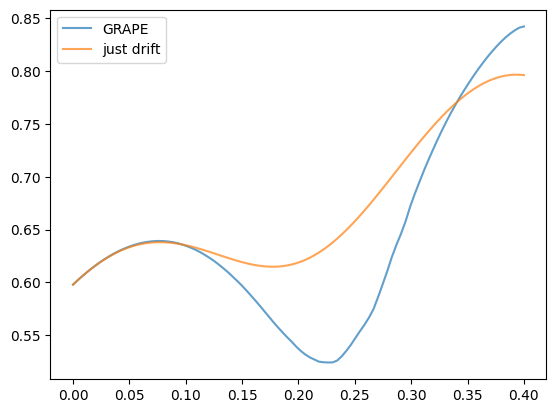

In [18]:
plt.plot(
    tspan,
    [qutip.metrics.fidelity(psi_target, psi) for psi in evolution_grape.states],
    alpha=0.7,
    label="GRAPE",
)

plt.plot(
    tspan,
    [qutip.metrics.fidelity(psi_target, psi) for psi in evolution_drift.states],
    alpha=0.7,
    label="just drift",
)

plt.legend()

Временная зависимость энтропии для гамильтониана с оптимальным контролем и основным

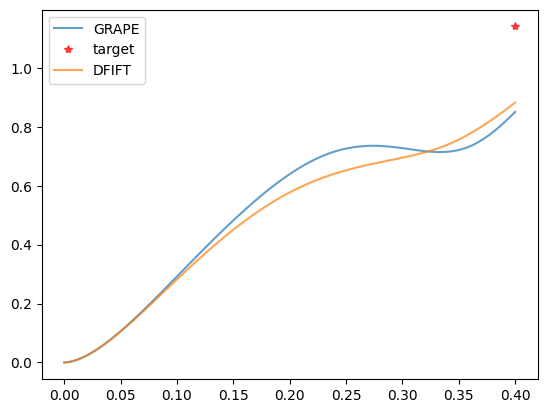

In [19]:
plt.plot(
    tspan,
    [qutip.entropy_vn(qutip.ptrace(psi, [0, 1])) for psi in evolution_grape.states],
    alpha=0.7,
    label="GRAPE",
)
plt.plot(
    tspan[-1],
    qutip.entropy_vn(qutip.ptrace(psi_target, [0, 1])),
    "*r",
    alpha=0.7,
    label="target",
)
plt.plot(
    tspan,
    [qutip.entropy_vn(qutip.ptrace(psi, [0, 1])) for psi in evolution_drift.states],
    alpha=0.7,
    label="DFIFT",
)

plt.legend()